# Generating convGRUnet 3D dataset
> Created August 2025 <br>
> Nikhil Bisht<br>

# Definitions

In [12]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd
import json

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/home/x-nbisht1/scratch/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
DENSITYCUBES = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_TimeseriesCubes_Density.npy'
MODELFILE = 'nnmodel.dict'

IMAGESIZE = 128

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


# Functions

In [17]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

def get_data(args, input_arr, labels):
    dataset = TensorDataset(input_arr, labels)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader


def img_transform(np_arr):
    return np.log10(np_arr)

def img_inverse_transform(np_arr):
    return np.power(10,np_arr)

def plot_img_raw(Initial_fname, Final_fname, save_filename='xy_data.png', dont_show = False):
    i_file = open(Initial_fname, 'r')
    infile = json.load(i_file)
    o_file = open(Final_fname, 'r')
    outfile = json.load(o_file)

    x1 = np.array(infile['img'])
    x1_label = infile['label']
    x2 = np.array(outfile['img'])
    x2_label = outfile['label']
    i_file.close()
    o_file.close()

    seq = x1.shape[0]
    fig = plt.figure(figsize=(12, 4*(seq+1)))
    fig.tight_layout()
    
    proj_arr = ['xy', 'yz', 'zx']
    for s in range(seq):
        for i in range(0,3):
            ax  = fig.add_subplot(seq+1, 3, 1+i+s*3)
            c = ax.pcolormesh(np.mean(x1[s], axis=i).T)
            fig.colorbar(c, ax=ax)
            ax.set_title(proj_arr[i]+' seq '+str(s)+' proj '+str(x1_label[0])+'_'+str(x1_label[1])+'_'+str(x1_label[2]))
            ax.grid('both')

    for i in range(0,3):
        ax2  = fig.add_subplot(seq+1, 3, 1+i+seq*3)
        c = ax2.pcolormesh(np.mean(x2, axis=i).T)
        fig.colorbar(c, ax=ax2)
        ax2.set_title(proj_arr[i]+' proj '+str(x2_label[0])+'_'+str(x2_label[1])+'_'+str(x2_label[2]))
        ax2.grid('both')

    if save_filename:
        plt.savefig(save_filename)
    
    if dont_show==False:
        plt.show()
    plt.close()


def data_augmentation_periodic(images_dictionary):
    new_imgs_dictionary = {}
    new_num = 0
    for num in images_dictionary.keys():
        initial_img = images_dictionary[str(num)]['initial_img']
        final_img = images_dictionary[str(num)]['final_img']
        img_frame = images_dictionary[str(num)]['label'][0]
        img_projection = images_dictionary[str(num)]['label'][1]

        #setup periodic wrap. shift to the right in steps of 64/4 = 16 pixels
        shift1_i, shift1_f = np.zeros(initial_img.shape), np.zeros(final_img.shape)
        shift2_i, shift2_f = np.zeros(initial_img.shape), np.zeros(final_img.shape)
        shift3_i, shift3_f = np.zeros(initial_img.shape), np.zeros(final_img.shape)
        
        shift1_i[:,:48,:,:], shift1_f[:48,:,:] = initial_img[:,16:,:,:], final_img[16:,:,:]
        shift1_i[:,48:,:,:], shift1_f[48:,:,:] = initial_img[:,0:16,:,:], final_img[0:16,:,:]

        shift2_i[:,:32,:,:], shift2_f[:32,:,:] = initial_img[:,32:,:,:], final_img[32:,:,:]
        shift2_i[:,32:,:,:], shift2_f[32:,:,:] = initial_img[:,0:32,:,:], final_img[0:32,:,:]

        shift3_i[:,:16,:,:], shift3_f[:16,:,:] = initial_img[:,48:,:,:], final_img[48:,:,:]
        shift3_i[:,16:,:,:], shift3_f[16:,:,:] = initial_img[:,0:48,:,:], final_img[0:48,:,:]

        new_imgs_dictionary[str(new_num)] = {'initial_img':initial_img, 'final_img': final_img, 'label': (img_frame,img_projection,0)}
        new_num+=1
        new_imgs_dictionary[str(new_num)] = {'initial_img':shift1_i,'final_img': shift1_f,'label': (img_frame,img_projection,1)}
        new_num+=1
        new_imgs_dictionary[str(new_num)] = {'initial_img':shift2_i,'final_img': shift2_f,'label': (img_frame,img_projection,2)}
        new_num+=1
        new_imgs_dictionary[str(new_num)] = {'initial_img':shift3_i,'final_img': shift3_f,'label': (img_frame,img_projection,3)}
        new_num+=1
    
    return new_imgs_dictionary

def data_augmentation_rotate(images_dictionary):
    from scipy import ndimage
    rotated_imgs_dictionary = {}
    new_num = 0
    for num in range(len(images_dictionary.keys())):
        initial_img = images_dictionary[str(num)]['initial_img']
        final_img = images_dictionary[str(num)]['final_img']
        img_frame = images_dictionary[str(num)]['label'][0]
        img_wrap = images_dictionary[str(num)]['label'][2]
        #setup rotation pairs: 4 rotations about y axis (0,2) and 2 rotations about x axis (1,2)
        rotation_in_degrees = [  0,     90,   180,   270,   90,     270]
        rotation_axes       = [(0,2), (0,2), (0,2), (0,2), (1,2), (1,2)]
        projection_label_name  = [ 'xy',    'yz',  'yx',   'zy',   'zx',   'xz']
        for rot_num in range(len(rotation_in_degrees)):
            rotated_initial_img = np.array([ndimage.rotate(iimg, rotation_in_degrees[rot_num], axes=rotation_axes[rot_num]) for iimg in initial_img])
            rotated_final_img = ndimage.rotate(final_img, rotation_in_degrees[rot_num], axes=rotation_axes[rot_num])
            rotated_imgs_dictionary[str(new_num)] = {'initial_img':rotated_initial_img,'final_img': rotated_final_img,'label': (img_frame,projection_label_name[rot_num],img_wrap)}
            new_num+=1

    return rotated_imgs_dictionary

def delete_folder_contents(folder):
    import shutil
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def store_imgs(img_dict, input_dir = None, output_dir = None, rewrite = 1):
    if rewrite==1:
        num = 0
        import shutil
        for folder in [input_dir, output_dir]:
            delete_folder_contents(folder)
    else:
        num = len(os.listdir(input_dir))
    for img_num in img_dict.keys():
        img_data = img_dict[img_num]
        input_fname = input_dir+"img_"+str(num).zfill(4)+".json"
        output_fname = output_dir+"img_"+str(num).zfill(4)+".json"
        num+=1
        if rewrite == 1:
            infile = open(input_fname, 'w')
            outfile = open(output_fname, 'w')
        if rewrite == 0 and os.path.isfile(input_fname):
            print("File exists!")
            return False
        initial_img = {'img': img_data['initial_img'].tolist(), 'label': img_data['label']}
        final_img = {'img': img_data['final_img'].tolist(), 'label': img_data['label']}
        json.dump(initial_img, infile, cls=NpEncoder)
        json.dump(final_img, outfile, cls=NpEncoder)
        if rewrite == 1:
            infile.close()
            outfile.close()

# Load Sample

In [3]:
#get data and prepare sample
#3D density Timeseries_Cube
infile = open(DENSITYCUBES, 'rb')
TSCube_density = np.load(infile)
time_array = np.load(infile)
infile.close()
dsample = nn.AvgPool3d(2)
print(TSCube_density.shape)
TSCube_density = dsample(torch.from_numpy(TSCube_density).unsqueeze(1))
print(TSCube_density.shape)
TSCube_density = TSCube_density.squeeze(1).numpy()
print(TSCube_density.shape)

(121, 128, 128, 128)
torch.Size([121, 1, 64, 64, 64])
(121, 64, 64, 64)


In [23]:
sequence_len = 5
IMAGEINPUT = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/Unet/Images_seq'+str(sequence_len)+'_Input_3D/'
IMAGEOUTPUT = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/Unet/Images_seq'+str(sequence_len)+'_Output_3D/'
FRAMES = np.arange(0,90-sequence_len+1, 1)
FRAME_DIFF = 30
images_dictionary = {}
num = len(images_dictionary.keys())
for frame in FRAMES:
    H_initial = []
    for seq in range(sequence_len):
        H_seq = img_transform(TSCube_density[frame+seq])
        H_initial.append(H_seq)
    H_initial = np.array(H_initial)
    H_final = img_transform(TSCube_density[frame+sequence_len-1+FRAME_DIFF])
    images_dictionary[str(num)] = {'initial_img':H_initial,'final_img': H_final,'label': (frame,'xy',0)}
    num+=1

images_dictionary = data_augmentation_rotate(images_dictionary)
images_dictionary = data_augmentation_periodic(images_dictionary)

store_imgs(images_dictionary,  input_dir = IMAGEINPUT, output_dir = IMAGEOUTPUT, rewrite = 1)

KeyboardInterrupt: 

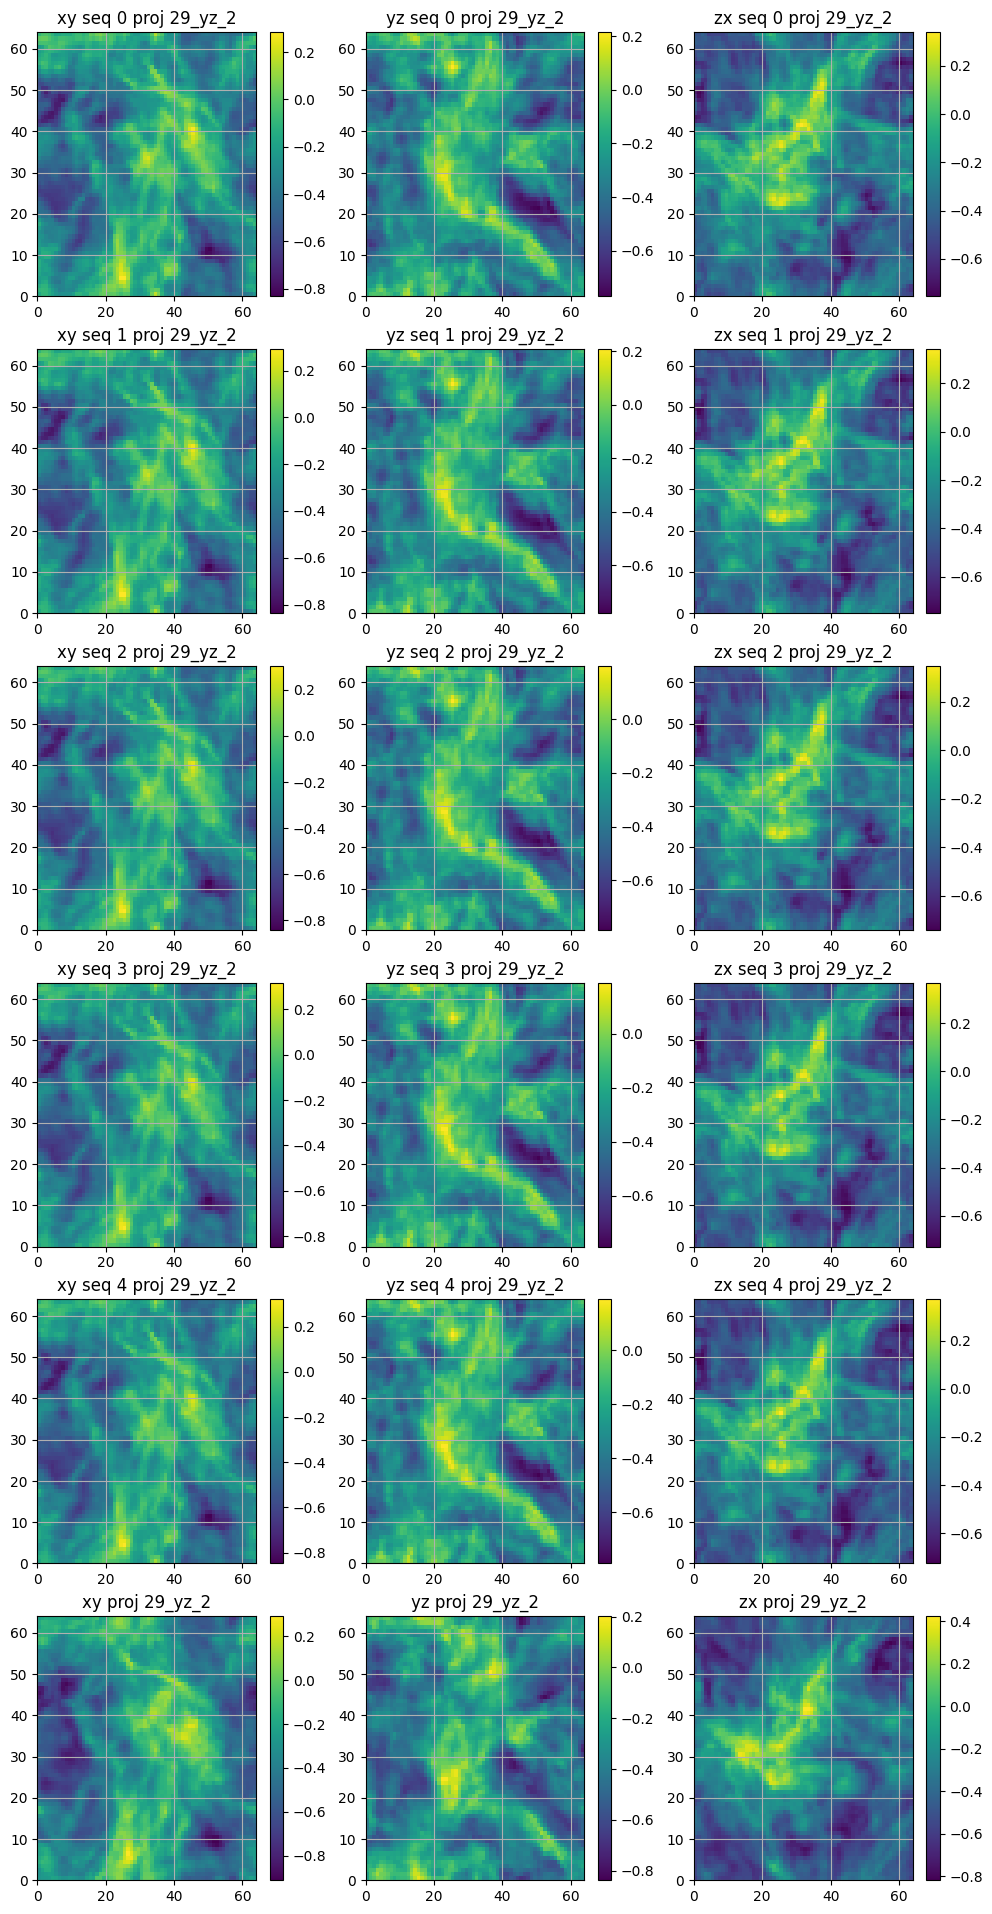

In [24]:
#Plot the images
delete_folder_contents('./seq'+str(sequence_len)+'_3D_img_plots/')
for num in range(len(images_dictionary.keys())-1000):
    img_num = str(num).zfill(4)
    plot_img_raw(IMAGEINPUT+"img_"+img_num+".json", IMAGEOUTPUT+"img_"+img_num+".json", save_filename='./seq'+str(sequence_len)+'_3D_img_plots/img'+img_num+'.png', dont_show = True)